In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

from dust_extinction.dust import extinction_cal

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928

In [4]:
lc_df = pd.read_hdf('/Users/adamamiller/astronomy/ZTF/SN19yvq/data/P48/SN2019yvq/data/photometry/P48/forcephot_product/lightcurves/ZTF19adcecwu_force_phot_nob.h5')

In [5]:
marshal_df = pd.read_csv('../data/phot/Marshal.lc')
marshal_df.head(5)

,date,jdobs,filter,absmag,magpsf,sigmamagpsf,limmag,instrument,programid,reducedby,refsys,issub,isdiffpos
0,2019 Dec 06,2.458824e+06,g,99.0,99.0,99.0,18.14,P48+ZTF,1,None,None,True,True
1,2019 Dec 10,2.458828e+06,r,99.0,99.0,99.0,19.26,P48+ZTF,1,None,None,True,True
2,2019 Dec 10,2.458828e+06,i,99.0,99.0,99.0,19.53,P48+ZTF,2,None,None,True,True
3,2019 Dec 10,2.458828e+06,i,99.0,99.0,99.0,19.58,P48+ZTF,2,None,None,True,True
4,2019 Dec 10,2.458828e+06,i,99.0,99.0,99.0,19.63,P48+ZTF,2,None,None,True,True


In [6]:
uvot_df = pd.read_csv('../data/phot/UVOT_hostsub.ascii',
                      delim_whitespace=True)
uvot_df.head()

,MJD,ISOT,FILTER,AB_FNU_mJy,AB_FNU_mJy_ERRM,AB_FNU_mJy_ERRP
0,58846.9019,2019-12-29T21:38:46.407,UVW2,0.314516,0.022726,0.023071
1,58846.9657,2019-12-29T23:10:36.241,UVW2,0.308226,0.022491,0.022268
2,58848.7636,2019-12-31T18:19:36.731,UVW2,0.055253,0.007696,0.007967
3,58848.9693,2019-12-31T23:15:47.658,UVW2,0.048824,0.007868,0.007814
4,58849.5536,2020-01-01T13:17:08.689,UVW2,0.044916,0.005618,0.005607


In [7]:
SNT=5
Fratio = lc_df["Fratio"].values
Fratio_unc = lc_df["Fratio_unc"].values
ix = Fratio > SNT*Fratio_unc


mags = -2.5 * np.log10(Fratio[ix])
emags = 2.5 / np.log(10) * Fratio_unc[ix] / Fratio[ix]
filt_id = lc_df.filterid.values

ulims = -2.5*np.log10(5*Fratio_unc[~ix])

In [8]:
phases = pd.read_csv("../playground/spec_phase.txt", delim_whitespace=True)

<IPython.core.display.Javascript object>


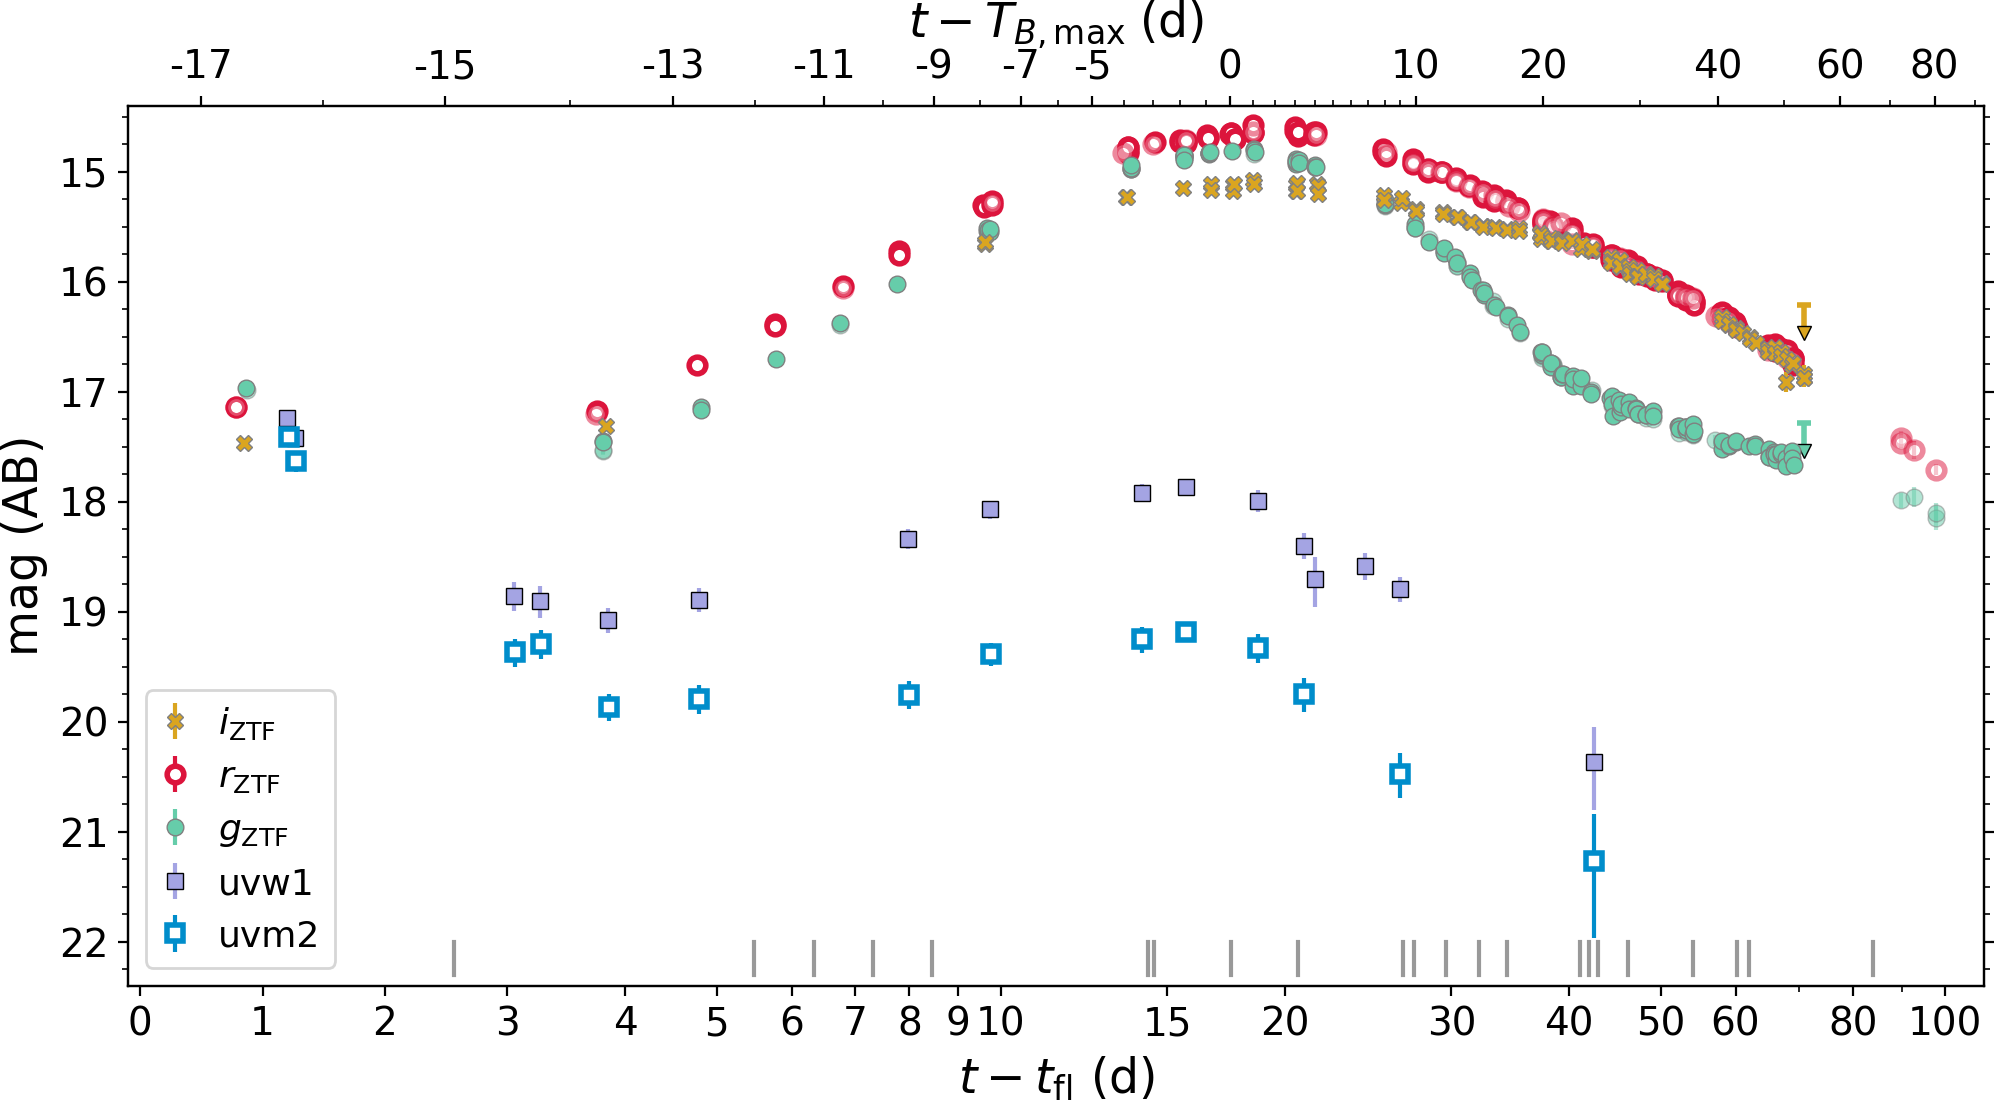

In [9]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 2,
            1: 0.5,
            3: 0.5}
filt_dict = {1:r'$g_\mathrm{ZTF}$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF}$'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}
str_dict = {3: 'i',
            1: 'g',
            2: 'r'}


fig, ax = plt.subplots(figsize=(10,5.5))

for filt in [3,2,1]:
    mag_filt = np.where(filt_id[ix] == filt)
    ax.errorbar((lc_df.jdobs.iloc[ix].values[mag_filt] - 2400000.5 - tb_max)/(1+z) - t_fl, 
                mags[mag_filt], emags[mag_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = filt_dict[filt], zorder = zorder_dict[filt])

    # Marshal LC
    this_lc = np.where((marshal_df['filter'] == str_dict[filt]) & 
                       (marshal_df['instrument'] == 'P48+ZTF') &
                       (marshal_df['programid'] == '1') &
                       (marshal_df['sigmamagpsf'] < 99))
    ax.errorbar((marshal_df.iloc[this_lc].jdobs.values - 2400000.5 - tb_max)/(1+z) - t_fl, 
            marshal_df.iloc[this_lc].magpsf.values, marshal_df.iloc[this_lc].sigmamagpsf.values, 
            fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
            mec=mec_dict[filt], mew=mew_dict[filt],
            alpha=0.5)

    
    ulim_filt = np.where(filt_id[~ix] == filt)
    ULoffset = 0.25
    yerr = np.zeros((2, len(ulim_filt[0])))
    yerr[0,:] += ULoffset
    ax.errorbar((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z) - t_fl, 
                ulims[ulim_filt]+ULoffset, yerr = yerr, 
                fmt = 'v', color = color_dict[filt], ms = 5, 
                elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
    ax.plot((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z) - t_fl, 
            ulims[ulim_filt], '_', 
            color = color_dict[filt], mew = 2, ms = 5)


### UVW1
uvw1_obs = np.where(uvot_df['FILTER'] == 'UVW1')
uvw1_time = (uvot_df.iloc[uvw1_obs].MJD.values - tb_max)/(1+z)-t_fl
uvw1_mag = -2.5*np.log10(uvot_df.iloc[uvw1_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvw1_mag + 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvw1_mag - 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvw1_mag_unc = np.vstack([plus_mag.values, minus_mag.values])

ax.errorbar(uvw1_time, uvw1_mag, uvw1_mag_unc, 
            fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
            mec='k', mew=0.5,
            label='uvw1')

### UVM2
uvm2_obs = np.where(uvot_df['FILTER'] == 'UVM2')
uvm2_time = (uvot_df.iloc[uvm2_obs].MJD.values - tb_max)/(1+z)-t_fl
uvm2_mag = -2.5*np.log10(uvot_df.iloc[uvm2_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvm2_mag + 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvm2_mag - 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvm2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])

ax.errorbar(uvm2_time, uvm2_mag, uvm2_mag_unc, 
            fmt = 's', color=mark_color_dict[2], ecolor=color_dict['uvm2'],
            mec=color_dict['uvm2'], mew=2,
            label='uvm2')

### UVW2
# uvw2_obs = np.where(uvot_df['FILTER'] == 'UVW2')
# uvw2_time = (uvot_df.iloc[uvw2_obs].MJD.values - tb_max)/(1+z)-t_fl
# uvw2_mag = -2.5*np.log10(uvot_df.iloc[uvw2_obs].AB_FNU_mJy/3.631e6)
# plus_mag = uvw2_mag + 2.5*np.log10((uvot_df.iloc[uvw2_obs].AB_FNU_mJy + 
#                                    uvot_df.iloc[uvw2_obs].AB_FNU_mJy_ERRP)/3.631e6)
# minus_mag = -uvw2_mag - 2.5*np.log10((uvot_df.iloc[uvw2_obs].AB_FNU_mJy - 
#                                    uvot_df.iloc[uvw2_obs].AB_FNU_mJy_ERRM)/3.631e6)
# uvw2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])

# ax.errorbar(uvw2_time, uvw2_mag, uvw2_mag_unc, 
#             fmt = 's', color=color_dict['uvw2'],
#             mec='k', mew=0.5,
#             label='uvw2', zorder=-10)


for phase in phases.phase.values:
    ax.plot([phase-t_fl, phase-t_fl],
            [22, 22.3], '0.6')

    
ax.set_ylim(22.4,14.4)
ax.set_ylabel(r'mag (AB)', fontsize=17)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_xlim(-0.1,110)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=17)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xscale("symlog", linthreshx=3, linscalex = 0.35, subsx = [2,3,4,5,6,7,8,9])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 80, 100])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 80, 100])
ax.tick_params(which='both', right=True, labelsize=14)

ax.legend(fancybox=True, loc=3, fontsize=13, 
          handlelength=0.8)

# set up time relative to T_Bmax
ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 17)
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale("symlog", linthreshx=3, linscalex = 0.35, subsx = [2,3,4,5,6,7,8,9])

bmax_ticks = [-17, -15, -13, -11, -9, -7, -5, 0, 10, 20, 40, 60, 80]
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.append(np.linspace(-20, 10, 31), np.linspace(20, 100, 9)) - t_fl))
ax2.tick_params(labelsize=14)

fig.subplots_adjust(left=0.064, bottom=0.104,top=0.904,right=0.992)
fig.savefig('../paper/figures/P48_lc.pdf')

<IPython.core.display.Javascript object>


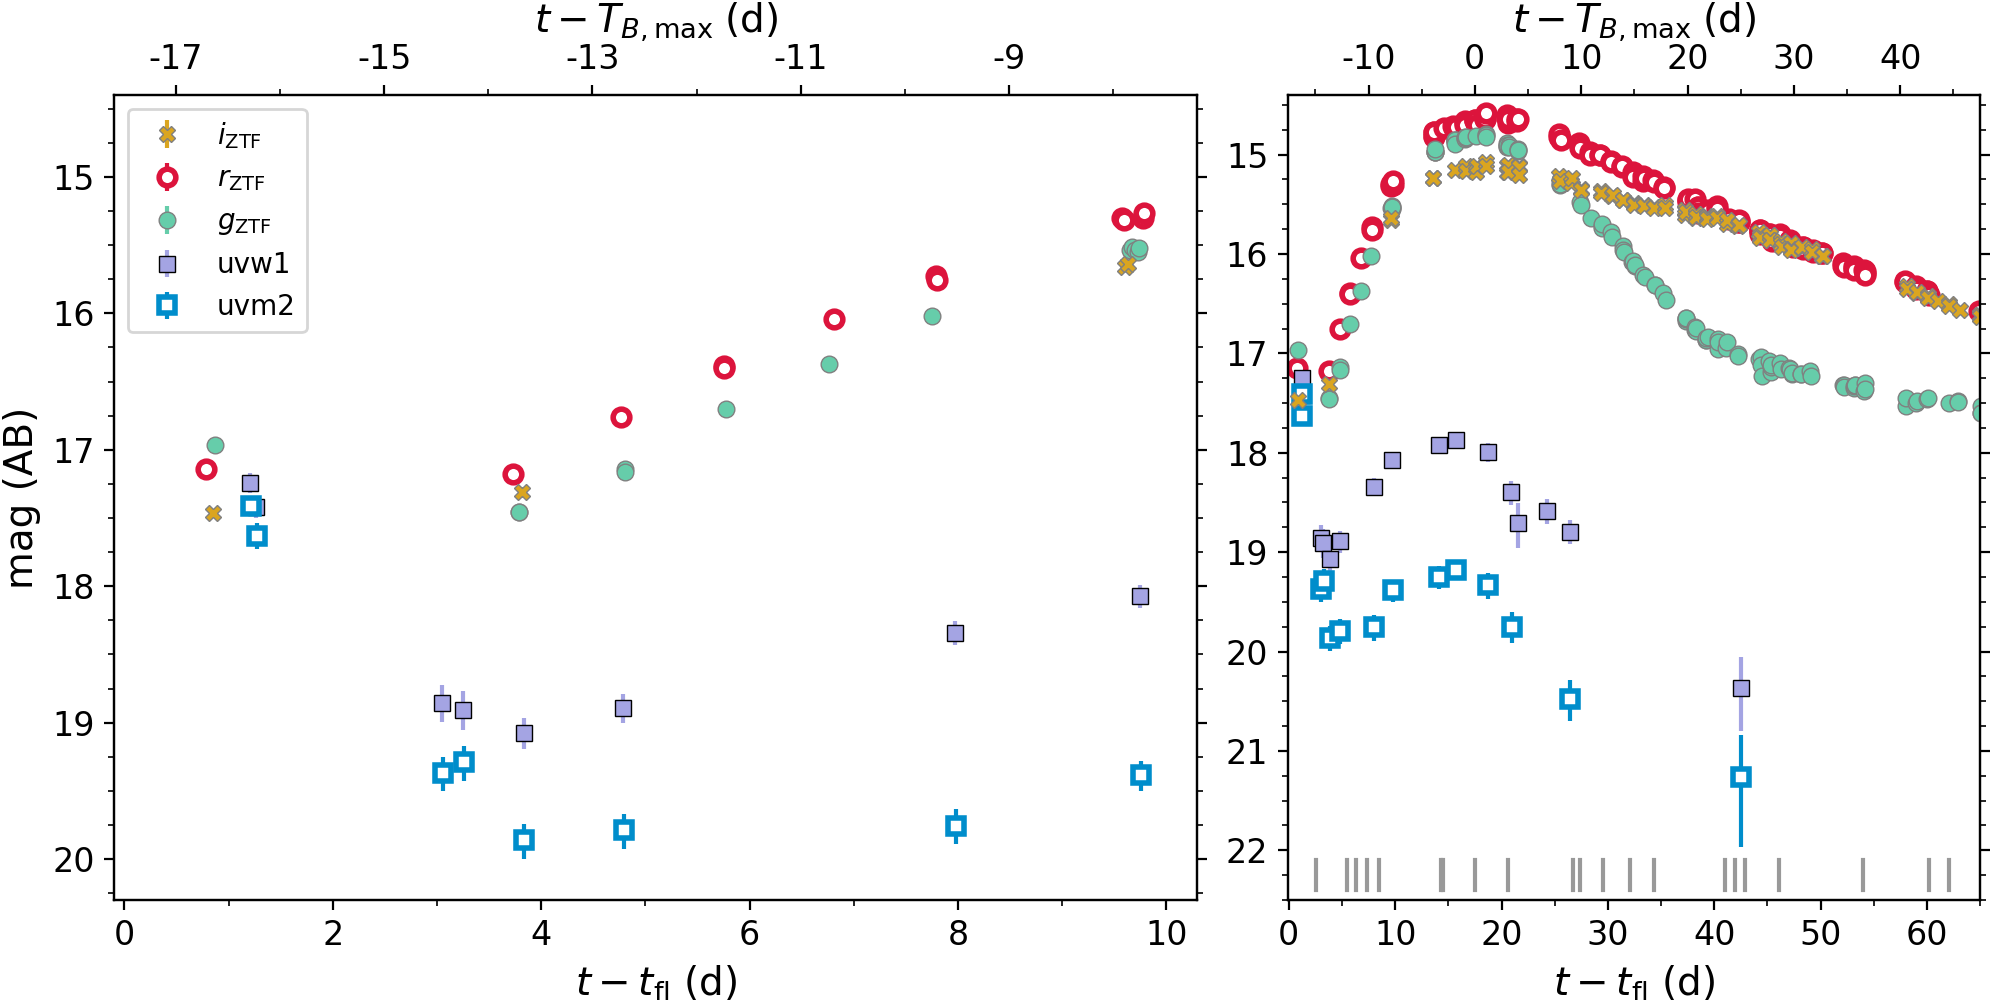

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


In [10]:
fig = plt.figure(figsize=(10,5), constrained_layout=True)

gs = GridSpec(1, 5, figure=fig)
ax = fig.add_subplot(gs[:, :-2])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax_all = fig.add_subplot(gs[:, -2:])


### HIGHLIGHT EARLY EVOLUTION
for filt in [3,2,1]:
    mag_filt = np.where(filt_id[ix] == filt)
    for a in [ax, ax_all]:
        a.errorbar((lc_df.jdobs.iloc[ix].values[mag_filt] - 2400000.5 - tb_max)/(1+z) - t_fl, 
                    mags[mag_filt], emags[mag_filt], 
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt],
                    label = filt_dict[filt], zorder = zorder_dict[filt])

    # Marshal LC
    this_lc = np.where((marshal_df['filter'] == filt_dict[filt]) & 
                       (marshal_df['instrument'] == 'P48+ZTF') &
                       (marshal_df['programid'] == '1') &
                       (marshal_df['sigmamagpsf'] < 99))
    for a in [ax, ax_all]:
        a.errorbar((marshal_df.iloc[this_lc].jdobs.values - 2400000.5 - tb_max)/(1+z) - t_fl, 
            marshal_df.iloc[this_lc].magpsf.values, marshal_df.iloc[this_lc].sigmamagpsf.values, 
            fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
            mec=mec_dict[filt], mew=mew_dict[filt],
            alpha=0.5)

    
    ulim_filt = np.where(filt_id[~ix] == filt)
    ULoffset = 0.25
    yerr = np.zeros((2, len(ulim_filt[0])))
    yerr[0,:] += ULoffset
    for a in [ax, ax_all]:
        a.errorbar((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z) - t_fl, 
                ulims[ulim_filt]+ULoffset, yerr = yerr, 
                fmt = 'v', color = color_dict[filt], ms = 5, 
                elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
        a.plot((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z) - t_fl, 
               ulims[ulim_filt], '_', 
               color = color_dict[filt], mew = 2, ms = 5)
    


### UVW1
uvw1_obs = np.where(uvot_df['FILTER'] == 'UVW1')
uvw1_time = (uvot_df.iloc[uvw1_obs].MJD.values - tb_max)/(1+z)-t_fl
uvw1_mag = -2.5*np.log10(uvot_df.iloc[uvw1_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvw1_mag + 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvw1_mag - 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvw1_mag_unc = np.vstack([plus_mag.values, minus_mag.values])

for a in [ax, ax_all]:
    a.errorbar(uvw1_time, uvw1_mag, uvw1_mag_unc, 
        fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
        mec='k', mew=0.5,
        label='uvw1')

### UVM2
uvm2_obs = np.where(uvot_df['FILTER'] == 'UVM2')
uvm2_time = (uvot_df.iloc[uvm2_obs].MJD.values - tb_max)/(1+z)-t_fl
uvm2_mag = -2.5*np.log10(uvot_df.iloc[uvm2_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvm2_mag + 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvm2_mag - 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvm2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])

for a in [ax, ax_all]:
    a.errorbar(uvm2_time, uvm2_mag, uvm2_mag_unc, 
            fmt = 's', color=mark_color_dict[2], ecolor=color_dict['uvm2'],
            mec=color_dict['uvm2'], mew=2,
            label='uvm2')

for phase in phases.phase.values:
    ax_all.plot([phase-t_fl, phase-t_fl],
            [22.1, 22.4], '0.6')

    
ax.set_ylim(20.3,14.4)
ax.set_ylabel(r'mag (AB)', fontsize=14)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_xlim(-0.1,10.3)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=14)
ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.set_xscale("symlog", linthreshx=3, linscalex = 0.25, subsx = [2,3,4,5,6,7,8,9])
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 8, 10])
# ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 8, 10])
ax.tick_params(which='both', right=True, labelsize=12)

ax.legend(fancybox=True, loc=2)

# set up time relative to T_Bmax
ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 14)
ax2.set_xlim(ax.get_xlim())
# ax2.set_xscale("symlog", linthreshx=3, linscalex = 0.25, subsx = [2,3,4,5,6,7,8,9])

bmax_ticks = [-17, -15, -13, -11, -9]
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.append(np.linspace(-20, 10, 31), np.linspace(20, 100, 9)) - t_fl))


#### Full light curve plot
ax_all.set_ylim(22.5,14.4)
# ax_all.set_ylabel(r'mag (AB)', fontsize=14)
ax_all.yaxis.set_minor_locator(MultipleLocator(0.25))

ax_all.set_xlim(-0.1,65)
ax_all.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=14)
ax_all.xaxis.set_major_locator(MultipleLocator(10))
ax_all.xaxis.set_minor_locator(MultipleLocator(5))
# ax.set_xscale("symlog", linthreshx=3, linscalex = 0.25, subsx = [2,3,4,5,6,7,8,9])
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 8, 10, 15])
# ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 8, 10, 15])
ax_all.tick_params(which='both', right=True, labelsize=12)

ax.legend(fancybox=True, loc=2)

# set up time relative to T_Bmax
ax2_all = ax_all.twiny()
ax2_all.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 14)
ax2_all.set_xlim(ax_all.get_xlim())
# ax2.set_xscale("symlog", linthreshx=3, linscalex = 0.25, subsx = [2,3,4,5,6,7,8,9])

ax2_all.set_xticks(np.arange(-10, 50, 10) - t_fl)
ax2_all.set_xticklabels(np.arange(-10, 50, 10), fontsize = 12)
ax2_all.xaxis.set_minor_locator(FixedLocator(np.arange(-15, 55, 10).astype(int) - t_fl))


fig.subplots_adjust(left=0.057, bottom=0.1,top=0.905,right=0.99, wspace=0.3)
# fig.savefig('../paper/figures/lc_wide.pdf')

In [11]:
# random notes on extinction
# effective wavelength for ZTF from: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Palomar/ZTF.g&&mode=browse&gname=Palomar&gname2=ZTF
# effective wavelength for SNe Ia from: Brown+11

print('Assuming R_v = 3.1 and E(B-V) = 0.25 then')
a_g = extinction_cal.calALambda(4722.74, 3.1, 0.25)
a_r = extinction_cal.calALambda(6339.61, 3.1, 0.25)
print('\tA_g - A_r ~ {:.4f} mag'.format(a_g - a_r))
print('\tA_g ~ {:.4f} mag'.format(a_g))
print('\tA_r ~ {:.4f} mag'.format(a_r))

a_uvw2 = extinction_cal.calALambda(3064., 3.1, 0.25)
a_uvm2 = extinction_cal.calALambda(2360., 3.1, 0.25)
a_uvw1 = extinction_cal.calALambda(3050., 3.1, 0.25)
print('\tA_uvw2 ~ {:.4f} mag'.format(a_uvw2))
print('\tA_uvm2 ~ {:.4f} mag'.format(a_uvm2))
print('\tA_uvw1 ~ {:.4f} mag'.format(a_uvw1))


Assuming R_v = 3.1 and E(B-V) = 0.25 then
	A_g - A_r ~ 0.3188 mag
	A_g ~ 0.9387 mag
	A_r ~ 0.6199 mag
	A_uvw2 ~ 1.3669 mag
	A_uvm2 ~ 2.0217 mag
	A_uvw1 ~ 1.3727 mag


In [12]:
print('Assuming R_v = 3.1 and E(B-V) = 0.05 then')
a_g = extinction_cal.calALambda(4722.74, 3.1, 0.05)
a_r = extinction_cal.calALambda(6339.61, 3.1, 0.05)
a_i = extinction_cal.calALambda(7886.13, 3.1, 0.05)
print('\tA_g - A_r ~ {:.4f} mag'.format(a_g - a_r))
print('\tA_g ~ {:.4f} mag'.format(a_g))
print('\tA_r ~ {:.4f} mag'.format(a_r))
print('\tA_i ~ {:.4f} mag'.format(a_i))

a_uvw2 = extinction_cal.calALambda(3064., 3.1, 0.05)
a_uvm2 = extinction_cal.calALambda(2360., 3.1, 0.05)
a_uvw1 = extinction_cal.calALambda(3050., 3.1, 0.05)
print('\tA_uvw2 ~ {:.4f} mag'.format(a_uvw2))
print('\tA_uvm2 ~ {:.4f} mag'.format(a_uvm2))
print('\tA_uvw1 ~ {:.4f} mag'.format(a_uvw1))

Assuming R_v = 3.1 and E(B-V) = 0.05 then
	A_g - A_r ~ 0.0638 mag
	A_g ~ 0.1877 mag
	A_r ~ 0.1240 mag
	A_i ~ 0.0876 mag
	A_uvw2 ~ 0.2734 mag
	A_uvm2 ~ 0.4043 mag
	A_uvw1 ~ 0.2745 mag


In [13]:
print('Assuming R_v = 1.7 and E(B-V) = 0.25 then')
a_g = extinction_cal.calALambda(4722.74, 1.7, 0.25)
a_r = extinction_cal.calALambda(6339.61, 1.7, 0.25)
print('\tA_g - A_r ~ {:.4f} mag'.format(a_g - a_r))
print('\tA_g ~ {:.4f} mag'.format(a_g))
print('\tA_r ~ {:.4f} mag'.format(a_r))

a_uvw2 = extinction_cal.calALambda(3064., 1.7, 0.25)
a_uvm2 = extinction_cal.calALambda(2360., 1.7, 0.25)
a_uvw1 = extinction_cal.calALambda(3050., 1.7, 0.25)
print('\tA_uvw2 ~ {:.4f} mag'.format(a_uvw2))
print('\tA_uvm2 ~ {:.4f} mag'.format(a_uvm2))
print('\tA_uvw1 ~ {:.4f} mag'.format(a_uvw1))

Assuming R_v = 1.7 and E(B-V) = 0.25 then
	A_g - A_r ~ 0.3101 mag
	A_g ~ 0.5884 mag
	A_r ~ 0.2783 mag
	A_uvw2 ~ 1.1203 mag
	A_uvm2 ~ 2.0571 mag
	A_uvw1 ~ 1.1294 mag


In [14]:
a_w2 = extinction_cal.calALambda(3064., 3.1, 0.05)
a_m2 = extinction_cal.calALambda(2360., 3.1, 0.05)
a_w1 = extinction_cal.calALambda(3050., 3.1, 0.05)

uvot_t_rf = (uvot_df.MJD.values - tb_max)/(1+z)-t_fl

a_uvot = np.zeros_like(uvot_t_rf)
for fid, alam in zip(['UVW2','UVM2','UVW1'], [a_w2, a_m2, a_w1]):
    a_uvot[np.where(uvot_df['FILTER'] == fid)] = alam

abs_mag_uvot = -2.5*np.log10(uvot_df.AB_FNU_mJy.values/3.631e6) - 33.14 - a_uvot
mag_unc_uvot = 2.5/np.log(10)*((uvot_df.AB_FNU_mJy_ERRM.values+uvot_df.AB_FNU_mJy_ERRP.values)/2)/uvot_df.AB_FNU_mJy.values
filt_uvot = uvot_df['FILTER'].values

In [15]:
ztf_t_rf = (lc_df.jdobs.iloc[ix].values - 2400000.5 - tb_max)/(1+z) - t_fl
a_ztf = np.zeros_like(mags)
for fid, alam in zip([1,2,3], [0.1877, 0.1240, 0.0876]):
    a_ztf[np.where(lc_df["filterid"].values[ix] == fid)] = alam

abs_mag_ztf = mags - 33.14 - a_ztf
mag_unc_ztf = emags
filt_ztf = lc_df['filter'][ix].values

abs_mag_df = pd.DataFrame(np.append(ztf_t_rf, uvot_t_rf), columns=['t_restframe'])

abs_mag_df['abs_mag'] = np.append(abs_mag_ztf, abs_mag_uvot)
abs_mag_df['mag_unc'] = np.append(mag_unc_ztf, mag_unc_uvot)
abs_mag_df['filt'] = np.append(filt_ztf.astype(str), filt_uvot)

abs_mag_df.to_csv('abs_mag_p48.csv', index=False)
abs_mag_df.head(5)

,t_restframe,abs_mag,mag_unc,filt
0,0.779844,-16.121753,0.015658,r
1,0.847793,-15.760670,0.014474,i
2,0.867332,-16.364536,0.010132,g
3,3.731084,-16.083966,0.017258,r
4,3.789436,-15.874392,0.015882,g


In [16]:
flux_df = pd.DataFrame(lc_df.jdobs.iloc[ix].values - 2400000.5, columns=['mjd'])

flux_df['flux'] = 3631*10**(-0.4*mags)
flux_df['flux_unc'] = emags*np.log(10)/2.5*3631*10**(-0.4*mags)
flux_df['filt'] = filt_ztf.astype(str)

flux_df.to_csv('flux_p48.csv', index=False)
flux_df.head(5)

,mjd,flux,flux_unc,filt
0,58846.469942,0.000505,0.000007,r
1,58846.538530,0.000374,0.000005,i
2,58846.558252,0.000595,0.000006,g
3,58849.448924,0.000488,0.000008,r
4,58849.507824,0.000379,0.000006,g


In [17]:
# make obs flux file for BB fit
ztf_t_rf = (lc_df.jdobs.iloc[ix].values - 2400000.5 - tb_max)/(1+z) - t_fl
ztf_flux = 3631*10**(-0.4*mags)
ztf_flux_unc = emags*np.log(10)/2.5*3631*10**(-0.4*mags)


obs_flux_df = pd.DataFrame(np.append(ztf_t_rf, uvot_t_rf), columns=['t_restframe'])

obs_flux_df['flux_Jy'] = np.append(ztf_flux, uvot_df.AB_FNU_mJy.values/1e3)
obs_flux_df['flux_unc_Jy'] = np.append(ztf_flux_unc, 
                                   (uvot_df.AB_FNU_mJy_ERRM.values+uvot_df.AB_FNU_mJy_ERRP.values)/2)
obs_flux_df['filt'] = np.append(filt_ztf.astype(str), filt_uvot)

obs_flux_df.to_csv('flux_obs_19yvq.csv', index=False)

## Make nice plot of color evolution

In [18]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('../data/comp_sne/colors/gr_adam.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


In [19]:
gr_jd = np.array([])
gr = np.array([])
gr_unc = np.array([])

ri_jd = np.array([])
ri = np.array([])
ri_unc = np.array([])


new_night = np.where(np.diff(lc_df.jdobs.iloc[ix].values) > 0.5)[0]
new_night = np.append(new_night, new_night[-1])
for night_num, night_idx in enumerate(new_night):
    if night_num == 0:
        start_tonight = 0
        end_tonight = night_idx+1
    elif night_num == len(new_night)-1:
        start_tonight = new_night[night_num-1]+1
        end_tonight = len(lc_df.jdobs.iloc[ix].values)
    else:
        start_tonight = new_night[night_num-1]+1
        end_tonight = night_idx+1

    tonight = np.arange(sum(ix))[start_tonight:end_tonight]
    snr_tonight = Fratio[ix][tonight]/Fratio_unc[ix][tonight]
    jd_tonight = np.average(lc_df.jdobs.iloc[ix].values[tonight], 
                            weights=snr_tonight**2)
    if 1 in filt_id[ix][tonight] and 2 in filt_id[ix][tonight]:
        g_tonight = np.where(filt_id[ix][tonight] == 1)
        r_tonight = np.where(filt_id[ix][tonight] == 2)
        gr_jd = np.append(gr_jd, jd_tonight)
        
        w_mean_g = np.average(Fratio[ix][tonight][g_tonight], 
                              weights = 1/Fratio_unc[ix][tonight][g_tonight]**2)
        w_mean_g_unc = np.sum(1/Fratio_unc[ix][tonight][g_tonight]**2)**(-0.5)

        w_mean_r = np.average(Fratio[ix][tonight][r_tonight], 
                              weights = 1/Fratio_unc[ix][tonight][r_tonight]**2)
        w_mean_r_unc = np.sum(1/Fratio_unc[ix][tonight][r_tonight]**2)**(-0.5)        
        
        gr = np.append(gr, -2.5*np.log10(w_mean_g/w_mean_r))
        gr_unc = np.append(gr_unc, 2.5 / np.log(10) * np.hypot(w_mean_g_unc/w_mean_g, 
                                                               w_mean_r_unc/w_mean_r))

    if 2 in filt_id[ix][tonight] and 3 in filt_id[ix][tonight]:
        r_tonight = np.where(filt_id[ix][tonight] == 2)
        i_tonight = np.where(filt_id[ix][tonight] == 3)
        ri_jd = np.append(ri_jd, jd_tonight)
        
        w_mean_r = np.average(Fratio[ix][tonight][r_tonight], 
                              weights = 1/Fratio_unc[ix][tonight][r_tonight]**2)
        w_mean_r_unc = np.sum(1/Fratio_unc[ix][tonight][r_tonight]**2)**(-0.5)

        w_mean_i = np.average(Fratio[ix][tonight][i_tonight], 
                              weights = 1/Fratio_unc[ix][tonight][i_tonight]**2)
        w_mean_i_unc = np.sum(1/Fratio_unc[ix][tonight][i_tonight]**2)**(-0.5)        
        
        ri = np.append(ri, -2.5*np.log10(w_mean_r/w_mean_i))
        ri_unc = np.append(ri_unc, 2.5 / np.log(10) * np.hypot(w_mean_r_unc/w_mean_r, 
                                                               w_mean_i_unc/w_mean_i))

In [20]:
with open('../playground/gr_colors.txt', 'w') as fw:
    print('jd,gr,gr_unc', file=fw)
    for j, c, c_unc in zip(gr_jd, gr, gr_unc):
        print('{},{},{}'.format(j,c,c_unc), file=fw)

In [21]:
uvw1_obs = np.where(uvot_df.FILTER == 'UVW1')
uvm2_obs = np.where(uvot_df.FILTER == 'UVM2')

uvm2uvw1_mjd = np.zeros_like(uvot_df.MJD.iloc[uvm2_obs].values)
uvm2uvw1 = np.zeros_like(uvm2uvw1_mjd)
uvm2uvw1_unc = np.zeros_like(uvm2uvw1_mjd)

for epoch, uvm2_mjd in enumerate(uvot_df.MJD.iloc[uvm2_obs].values):
    uvw1_match = np.argmin(np.abs(uvm2_mjd - uvot_df.MJD.iloc[uvw1_obs].values))
    if np.abs(uvm2_mjd - uvot_df.MJD.iloc[uvw1_obs].values[uvw1_match]) < 0.2:
        uvm2uvw1_mjd[epoch] = (uvm2_mjd + uvot_df.MJD.iloc[uvw1_obs].values[uvw1_match])/2

        
        
        uvm2mag_snr = uvot_df.AB_FNU_mJy.iloc[uvm2_obs].values[epoch]/(
                     (uvot_df.AB_FNU_mJy_ERRM.iloc[uvm2_obs].values[epoch] + 
                      uvot_df.AB_FNU_mJy_ERRP.iloc[uvm2_obs].values[epoch])/2)
        uvm2mag_unc = 2.5/np.log(10)/uvm2mag_snr
        
        uvm1mag_snr = uvot_df.AB_FNU_mJy.iloc[uvw1_obs].values[uvw1_match]/(
                     (uvot_df.AB_FNU_mJy_ERRM.iloc[uvw1_obs].values[uvw1_match] + 
                      uvot_df.AB_FNU_mJy_ERRP.iloc[uvw1_obs].values[uvw1_match])/2)
        uvw1mag_unc = 2.5/np.log(10)/uvm1mag_snr
                
        uvm2uvw1[epoch] = -2.5*np.log10(uvot_df.AB_FNU_mJy.iloc[uvm2_obs].values[epoch]/
                                        uvot_df.AB_FNU_mJy.iloc[uvw1_obs].values[uvw1_match])
        uvm2uvw1_unc[epoch] = np.hypot(uvm2mag_unc,uvw1mag_unc)

In [22]:
bv_jd = np.array([])
bv = np.array([])
bv_unc = np.array([])

ub_jd = np.array([])
ub = np.array([])
ub_unc = np.array([])

uvm2u_jd = np.array([])
uvm2u = np.array([])
uvm2u_unc = np.array([])

new_night = np.where(np.diff(marshal_df.jdobs.values) > 0.5)[0]
new_night = np.append(new_night, new_night[-1])
for night_num, night_idx in enumerate(new_night):
    if night_num == 0:
        start_tonight = 0
        end_tonight = night_idx+1
    elif night_num == len(new_night)-1:
        start_tonight = new_night[night_num-1]+1
        end_tonight = len(lc_df.jdobs.iloc[ix].values)
    else:
        start_tonight = new_night[night_num-1]+1
        end_tonight = night_idx+1

    tonight = np.arange(len(marshal_df))[start_tonight:end_tonight]
    if 'B' in marshal_df['filter'].iloc[tonight].values and 'V' in marshal_df['filter'].iloc[tonight].values:
        filts_tonight = marshal_df['filter'].iloc[tonight]
        jd_tonight = marshal_df['jdobs'].iloc[tonight].values
        mag_tonight = marshal_df['magpsf'].iloc[tonight].values
        mag_unc_tonight = marshal_df['sigmamagpsf'].iloc[tonight].values
        b_tonight = np.where(filts_tonight == 'B')
        v_tonight = np.where(filts_tonight == 'V')

        
        bv_jd = np.append(bv_jd, 
                          np.mean(jd_tonight[np.where((filts_tonight == 'B') |
                                                      (filts_tonight == 'V'))]))
        bv = np.append(bv, 
                       mag_tonight[b_tonight] -  mag_tonight[v_tonight])
        bv_unc = np.append(bv_unc, 
                           np.hypot(mag_unc_tonight[b_tonight],mag_unc_tonight[v_tonight]))
        
    if 'u' in marshal_df['filter'].iloc[tonight].values and 'UVM2' in marshal_df['filter'].iloc[tonight].values:
        filts_tonight = marshal_df['filter'].iloc[tonight]
        jd_tonight = marshal_df['jdobs'].iloc[tonight].values
        mag_tonight = marshal_df['magpsf'].iloc[tonight].values
        mag_unc_tonight = marshal_df['sigmamagpsf'].iloc[tonight].values
        uvm2_tonight = np.where(filts_tonight == 'UVM2')
        u_tonight = np.where(filts_tonight == 'u')

        
        uvm2u_jd = np.append(uvm2u_jd, 
                          np.mean(jd_tonight[np.where((filts_tonight == 'UVM2') |
                                                      (filts_tonight == 'u'))]))
        uvm2u = np.append(uvm2u, 
                          mag_tonight[uvm2_tonight] -  mag_tonight[u_tonight])
        uvm2u_unc = np.append(uvm2u_unc, 
                              np.hypot(mag_unc_tonight[uvm2_tonight],mag_unc_tonight[u_tonight]))
    
    if 'u' in marshal_df['filter'].iloc[tonight].values and 'B' in marshal_df['filter'].iloc[tonight].values:
        filts_tonight = marshal_df['filter'].iloc[tonight]
        jd_tonight = marshal_df['jdobs'].iloc[tonight].values
        mag_tonight = marshal_df['magpsf'].iloc[tonight].values
        mag_unc_tonight = marshal_df['sigmamagpsf'].iloc[tonight].values
        b_tonight = np.where(filts_tonight == 'B')
        u_tonight = np.where(filts_tonight == 'u')

        
        ub_jd = np.append(ub_jd, 
                          np.mean(jd_tonight[np.where((filts_tonight == 'B') |
                                                      (filts_tonight == 'u'))]))
        ub = np.append(ub, 
                          mag_tonight[u_tonight] -  mag_tonight[b_tonight])
        ub_unc = np.append(ub_unc, 
                              np.hypot(mag_unc_tonight[u_tonight],mag_unc_tonight[b_tonight]))

<IPython.core.display.Javascript object>


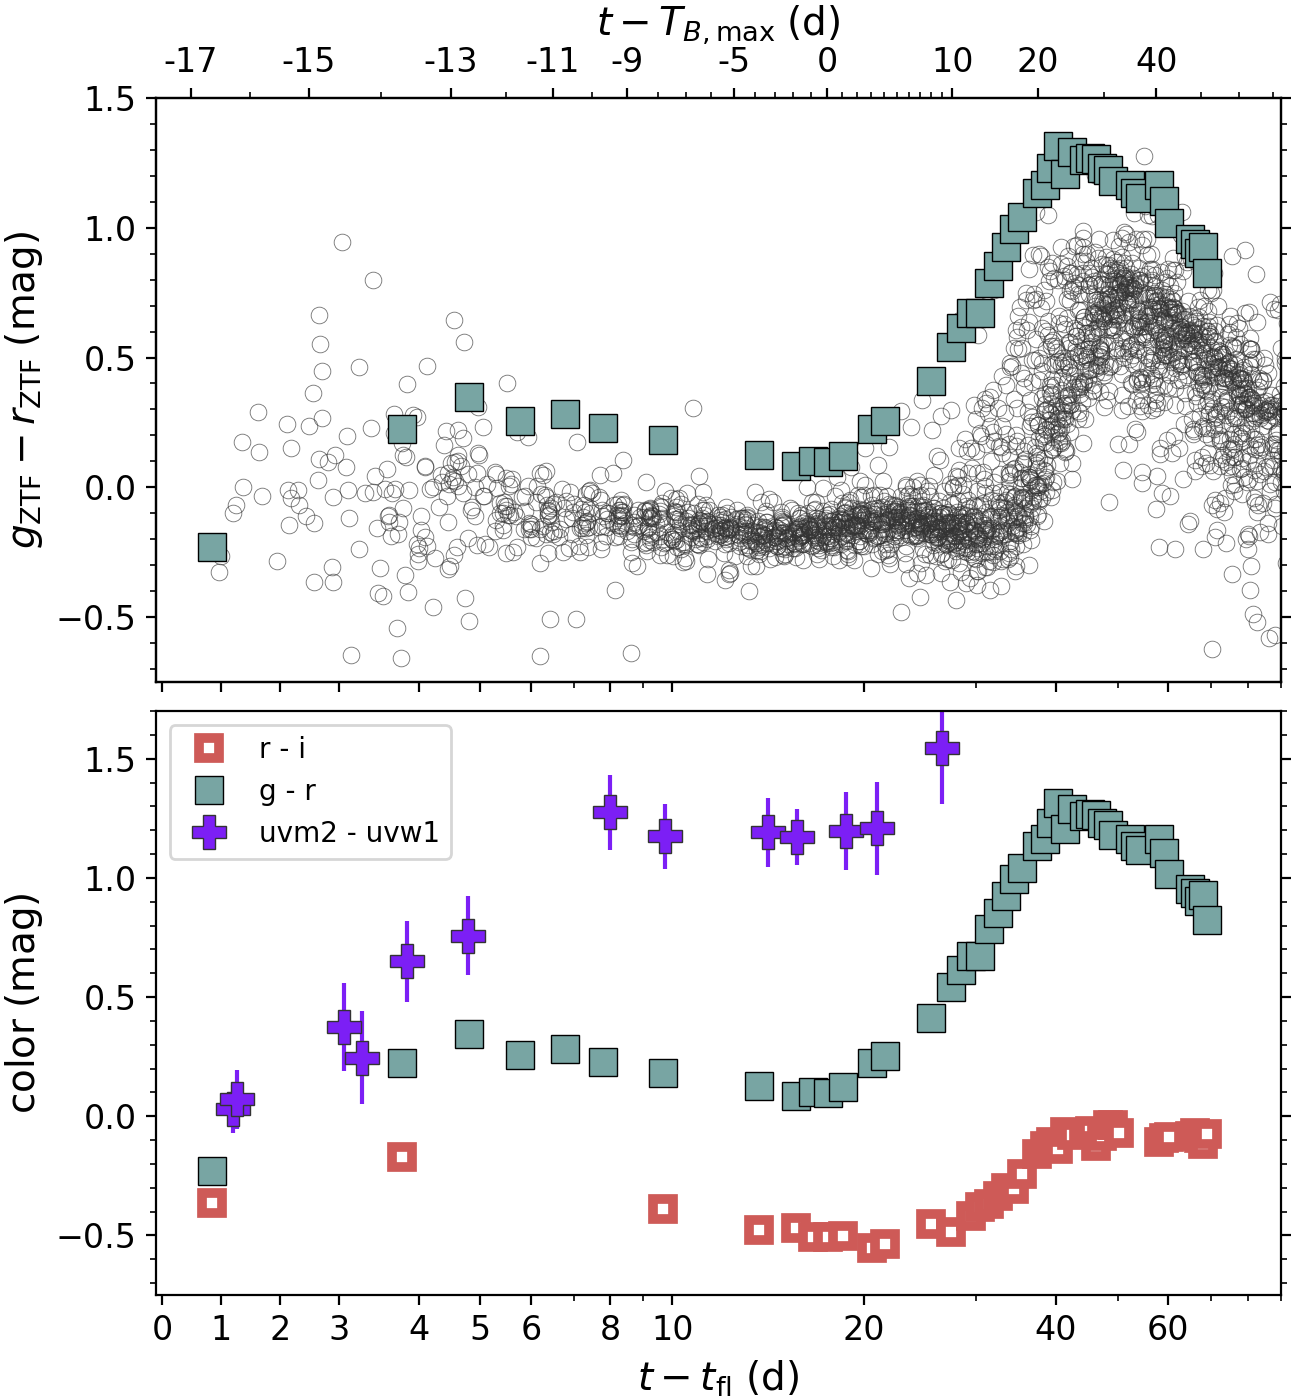

In [23]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}


fig, (ax, ax1) = plt.subplots(2,1, 
                              sharex=True, 
                              figsize=(6.5,7))

ax.plot(gr_population.iloc[normal_ia].t.values, 
        gr_population.iloc[normal_ia].gr.values,
        'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)

# this_sn = np.where(gr_population.SN == 'ZTF18abeegsl')
# ax.plot(gr_population.iloc[this_sn].t.values, 
#         gr_population.iloc[this_sn].gr.values,
#         'o', color='DarkOrange')

    
ax1.errorbar((ri_jd - 2400000.5 - tb_max)/(1+z) - t_fl, 
            ri - 0.04, ri_unc, label='r - i',
            fmt='s', color='white',
            mec = aam_colors['punch'], ms=7, mew=3.5)

for ap in [ax, ax1]:
    ap.errorbar((gr_jd - 2400000.5 - tb_max)/(1+z) - t_fl, 
                gr - 0.05, gr_unc, label='g - r',
                fmt='s', color=aam_colors['ocean'] , ms=10, mec='k', mew=0.5)
    ap.tick_params(which='both', right=True, labelsize=12)

ax1.errorbar((uvm2uvw1_mjd[:-1] - tb_max)/(1+z) - t_fl, 
             uvm2uvw1[:-1] - 0.14, uvm2uvw1_unc[:-1], label='uvm2 - uvw1',
            fmt='P', color='#7C1FF5',
            mec = '0.2', ms=12, mew=0.5)
# ax1.errorbar((uvm2u_jd - 2400000.5 - tb_max)/(1+z) - t_fl, 
#              uvm2u, uvm2u_unc, label='UVM2 - U',
#             fmt='H', color='white',
#             mec = 'MediumVioletRed', ms=7, mew=3.5)
# ax1.errorbar((ub_jd - 2400000.5 - tb_max)/(1+z) - t_fl, 
#              ub, ub_unc, label='U - B',
#              fmt='H', color='white',
#              mec = 'MediumVioletRed', ms=7, mew=3.5)


ax.set_ylim(-0.75,1.5)
ax.set_xlim((-0.1,90))
ax.set_ylabel(r'$g_\mathrm{ZTF} - r_\mathrm{ZTF} \;(\mathrm{mag})$', fontsize=14)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xscale("symlog", linthreshx=3, linscalex = 0.25, subsx = [2,3,4,5,6,7,8,9])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 8, 10, 20,  40, 60])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 8, 10, 20,  40, 60])

ax1.set_ylim(-0.75,1.7)
ax1.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=14)
ax1.set_ylabel(r'$\mathrm{color} \;(\mathrm{mag})$', fontsize=14)
# ax1.set_ylim(-0.7,2.9)
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.legend(fancybox=True)


# set up time relative to T_Bmax
ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 14)
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale("symlog", linthreshx=3, linscalex = 0.25, subsx = [2,3,4,5,6,7,8,9])

bmax_ticks = [-17, -15, -13, -11, -9, -5, 0, 10, 20, 40]
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.append(np.linspace(-20, 10, 31), np.linspace(20, 100, 9)) - t_fl))

fig.subplots_adjust(left=0.12, bottom=0.075,top=0.93,right=0.985,hspace=0.05)
fig.align_ylabels()
fig.savefig('../paper/figures/P48_colors.pdf')